In [2]:
import os
import ast
import collections

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
from scipy.spatial import distance

import torch
from torch_geometric import seed_everything
from torch_geometric.data import HeteroData
from torch_geometric.utils import homophily, subgraph
import torch_geometric.transforms as T
import torch.nn.functional as F

seed_everything(42)

In [3]:
# Config

DATA_DIR = '/mnt/graphdata/lpa/'
FEATURES_DIR = '/mnt/graphdata/features/community'
RANDOM_SEED = 42

IS_MULTI_LABEL = True
FEATURES_HIERARCHICAL_LEVEL = 2 # 0-4
METADATA_TYPE = 'tissue' # 'tissue' or 'taxon'
WEIGHT_THRESHOLD = 0.75
REMOVE_ISOLATED_NODES = True

In [4]:
class IdentityEncoder(object):
    # The 'IdentityEncoder' takes the raw column values and converts them to
    # PyTorch tensors.
    def __init__(self, dtype=None, is_list=False, is_tensor=False):
        self.dtype = dtype
        self.is_list = is_list
        self.is_tensor = is_tensor

    def __call__(self, df):
        if self.is_tensor:
            if self.is_list:
                return torch.stack([torch.tensor([el]) for el in df.values])
            return torch.from_numpy(df.values).to(self.dtype)
        else:
            return df

class ListEncoder(object):
    def __init__(self, sep=',', is_tensor=False):
        self.sep = sep
        self.is_tensor = is_tensor

    def __call__(self, df):
        eval_df = df.apply(
            lambda x: [val for val in ast.literal_eval(x)])
        return torch.stack([torch.tensor(el) for el in eval_df.values])


def get_label_from_communities(communities, level=FEATURES_HIERARCHICAL_LEVEL):
    if 'intermediateCommunityIds' not in communities.columns:
        communities['targetLevel'] = communities['communityId']
    else:    
        communities['targetLevel'] = communities['intermediateCommunityIds'].apply(lambda x: ast.literal_eval(x)[level])
    return communities


def load_node_tensor(df, index_col, encoders=None):
    mapping = {index: i for i, index in enumerate(df[index_col].unique())}
    x = torch.ones(size=(len(df.index), 1))

    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)
        x = x.float()
    
    assert len(mapping) == len(df.index.unique())
    return x, mapping

def load_edge_tensor(df, src_index_col, src_mapping,
                     dst_index_col, dst_mapping, encoders=None):
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr


def get_single_class_encoding(sotu_nodes, sotu_tissues, tissue_fts):
    if METADATA_TYPE == 'tissue':
        md_key = 'btoId'
        run_col = 'numRuns'
    elif METADATA_TYPE == 'taxon':
        md_key = 'taxId'
        run_col = 'count'

    most_common = sotu_tissues.groupby('sotu')[run_col].idxmax()
    most_common = sotu_tissues.loc[most_common]

    sotu_fts = pd.merge(
        most_common,
        tissue_fts[['nodeId', 'appId', 'targetLevel']],
        left_on=md_key, 
        right_on='appId',
        how='left')
    sotu_fts = pd.merge(
        sotu_nodes,
        sotu_fts[['sotu', 'targetLevel']],
        left_on='sotu', 
        right_on='sotu',
        how='left')
    
    # fill missing values with max targetLevel + 1
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(sotu_fts['targetLevel'].max() + 1)
    # sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(-1)
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(int)

    return sotu_fts


def get_multi_class_encoding(sotu_nodes, sotu_tissues, tissue_fts, mappings):
    if METADATA_TYPE == 'tissue':
        md_key = 'btoId'
    elif METADATA_TYPE == 'taxon':
        md_key = 'taxId'
    sotu_fts = pd.merge(
        sotu_tissues,
        tissue_fts[['nodeId', 'appId', 'targetLevel']],
        left_on=md_key, 
        right_on='appId',
        how='left')
    sotu_fts = pd.merge(
        sotu_nodes,
        sotu_fts[['sotu', 'targetLevel']],
        left_on='sotu', 
        right_on='sotu',
        how='left')
    # fill missing values with max targetLevel + 1
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(sotu_fts['targetLevel'].max() + 1)
    # sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(-1)
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(int)
    sotu_fts = sotu_fts.groupby('sotu')['targetLevel'].apply(list).reset_index()

    # convert to one-hot encoding using MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    sotu_fts['targetLevel'] = mlb.fit_transform(sotu_fts['targetLevel']).tolist()
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(str)

    mappings['sotu_x'] = mlb.classes_

    return sotu_fts


def create_pyg_graph(
        hierarchy_level=FEATURES_HIERARCHICAL_LEVEL,
        weight_threshold=WEIGHT_THRESHOLD,
):
    data = HeteroData()
    mappings = {}

    # tissue_nodes = pd.read_csv(f'{DATA_DIR}/all_tissues.csv', index_col=False)
    # tissue_edges = pd.read_csv(f'{DATA_DIR}/tissue_edges.csv', index_col=False)

    sotu_nodes = pd.read_csv(f'{DATA_DIR}/sotu_nodes.csv', index_col=False)
    sotu_edges = pd.read_csv(f'{DATA_DIR}/sotu_sequence_alignment_edges.csv', index_col=False)

    if METADATA_TYPE == 'tissue':
        sotu_metadata =  pd.read_csv(f'{DATA_DIR}/sotu_tissues.csv', index_col=False)
        metadata_fts = pd.read_csv(f'{FEATURES_DIR}/tissue_leiden_communities.csv', index_col=False)

    elif METADATA_TYPE == 'taxon':
        sotu_metadata = pd.read_csv(f'{DATA_DIR}/sotu_has_inferred_taxon_edges.csv', index_col=False)
        sotu_metadata = sotu_metadata.rename(columns={'targetAppId': 'taxId', 'sourceNode': 'nodeId', 'sourceAppId': 'sotu'})
        metadata_fts = pd.read_csv(f'{FEATURES_DIR}/taxon_leiden_communities.csv', index_col=False)

    metadata_fts = get_label_from_communities(metadata_fts, level=hierarchy_level)

    print(f'Total number of classes: {metadata_fts["targetLevel"].nunique()}')

    if IS_MULTI_LABEL:
        sotu_fts = get_multi_class_encoding(sotu_nodes, sotu_metadata, metadata_fts, mappings)
    else:
        sotu_fts = get_single_class_encoding(sotu_nodes, sotu_metadata, metadata_fts)

    sotu_x, sotu_mapping = load_node_tensor(
        df=sotu_fts,
        index_col='sotu',
        encoders={
            'targetLevel': ListEncoder(is_tensor=True) if IS_MULTI_LABEL else IdentityEncoder(dtype=torch.long, is_tensor=True)
        }
    )
    sotu_x = sotu_x.long()
    data['sotu'].x = sotu_x
    mappings['sotu'] = sotu_mapping

    print(f'SOTU nodes: {sotu_x.shape}')

    sotu_edges = sotu_edges[sotu_edges['weight'] > weight_threshold]
    sotu_edge_index, sotu_edge_attr = load_edge_tensor(
        df=sotu_edges,
        src_index_col='sourceAppId',
        src_mapping=sotu_mapping,
        dst_index_col='targetAppId',
        dst_mapping=sotu_mapping,
        encoders={
            'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
        } 
    )
    data['sotu'].edge_index = sotu_edge_index
    data['sotu'].edge_attr = sotu_edge_attr
    print(f'SOTU edges: {sotu_edge_index.shape}')

    data = T.ToUndirected()(data)

    return data, mappings

In [6]:
data, mappings = create_pyg_graph()

Total number of classes: 195
SOTU nodes: torch.Size([513176, 145])
SOTU edges: torch.Size([2, 26341751])


In [5]:
# Jaccard similarity can be slow to compute for large datasets since it is not vectoriezed
# there is some legacy behaviour with calculating jaccard vs. hamming and how 0s are treated in binary vectors
# https://stackoverflow.com/a/37004489

def multi_class_homophily(edge_index, labels):
    edges = torch.transpose(edge_index, 0, 1)
    support = 0.0
    print(f'Number of edges: {edges.shape[0]}')
    for i, edge in enumerate(edges):
        if i % 500000 == 0:
            print(f'Processed {i} edges')
        if edge[0] == edge[1]:
            continue
        
        l1 = labels[edge[0].item()]
        l2 = labels[edge[1].item()]
        # if target_index is not None and l1[target_index] != 1 or l2[target_index] != 1:
        #     continue

        ## v1: use jaccard score        
        # support = support + jaccard_score(l1, l2)
        # support = support + (distance.hamming(l1, l2))

        ## v2: vectorized jaccard
        dist = pairwise_distances(
            np.array([
                l1.bool(),
                l2.bool(),
            ]), metric='jaccard')
        dist = 1 - dist[0][1]
        support = support + dist

    hp = support / edges.shape[0]
    return hp

def single_class_homophily(edge_index, labels):
    edge_homophily = homophily(edge_index, labels, method="edge")
    node_homophily = homophily(edge_index, labels, method="node")
    class_insensitive_homophily = homophily(edge_index, labels, method="edge_insensitive")
    return edge_homophily, node_homophily, class_insensitive_homophily


def get_single_class_homophily_of_multi_encoding(edge_index, labels, target_index):
    labels_at_idx = [label[target_index] for label in labels]
    labels_at_idx = torch.tensor(labels_at_idx).long()
    edge_homophily, node_homophily, class_insensitive_homophily = single_class_homophily(edge_index, labels_at_idx)
    return edge_homophily, node_homophily, class_insensitive_homophily



# if IS_MULTI_LABEL:
#     print(multi_class_homophily(data['sotu'].edge_index, data['sotu'].x))
# else:
#     print(single_class_homophily(data['sotu'].edge_index, data['sotu'].x))


/tmp/ipykernel_12007/964932942.py:40: UserWarning: The palette list has more values (5) than needed (1), which may not be intended.
  sns.lineplot(data=df, x='Weight Threshold', y=y_key, hue='Hierarchy Level', marker='o', palette=palette)


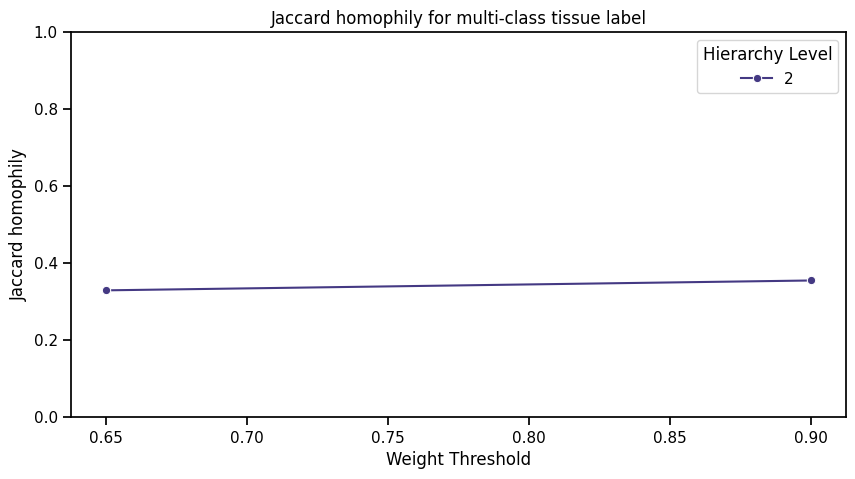

In [9]:
def get_homophily_plot_data():
    multi_class_str = 'multi' if IS_MULTI_LABEL else 'single' 
    filename = f'/mnt/graphdata/lpa/homophily_plot_data_{METADATA_TYPE}_{multi_class_str}.csv'
    if os.path.exists(filename):
        return pd.read_csv(filename)
    plot_data_rows = []
    for hierarchy_level in range(5):
    # for hierarchy_level in [2]:
        # for weight_threshold in np.arange(0.4, 0.95, 0.1):
        for weight_threshold in np.arange(0.65, 0.95, 0.25):
            data, mappings = create_pyg_graph(hierarchy_level=hierarchy_level, weight_threshold=weight_threshold)
            jaccard_homophily = edge_homophily = node_homophily = class_insensitive_homophily = None
            if IS_MULTI_LABEL:
                jaccard_homophily = multi_class_homophily(data['sotu'].edge_index, data['sotu'].x)
            else:
                edge_homophily, node_homophily, class_insensitive_homophily = single_class_homophily(data['sotu'].edge_index, data['sotu'].x)

            plot_data_rows.append({
                'Hierarchy Level': hierarchy_level,
                'Weight Threshold': weight_threshold,
                'Jaccard homophily': jaccard_homophily,
                'Edge homophily': edge_homophily,
                'Node homophily': node_homophily,
                'Class-insensitive homophily': class_insensitive_homophily
            })

    df = pd.DataFrame(plot_data_rows)
    df.to_csv(filename, index=False)
    return df

def plot_homophily(df):
    # sns.set_theme(style="whitegrid")
    sns.set_context("paper")
    sns.set_context("notebook")

    
    y_key = 'Jaccard homophily' if  IS_MULTI_LABEL else 'Edge homophily' 
    plt.figure(figsize=(10, 5))
    palette = sns.color_palette("viridis", n_colors=5)
    sns.lineplot(data=df, x='Weight Threshold', y=y_key, hue='Hierarchy Level', marker='o', palette=palette)
    
    # set y-axis to 0-1
    class_str = 'multi-class' if IS_MULTI_LABEL else 'single-class'
    plt.ylim(0, 1)
    plt.title(f'{y_key} for {class_str} {METADATA_TYPE} label')
    plt.show()

df = get_homophily_plot_data()
plot_homophily(df)

In [13]:
homophily_df = pd.read_csv(f'/mnt/graphdata/lpa/homophily_plot_data_class_breakdown_{METADATA_TYPE}.csv')
print(homophily_df)

     Hierarchy Level  Class label  Edge homophily  Node homophily  \
0                1.0          0.0        0.999098        0.152792   
1                1.0          1.0        0.998116        0.152501   
2                1.0          2.0        0.999527        0.152845   
3                1.0          3.0        0.999197        0.152818   
4                1.0          4.0        0.998843        0.152669   
..               ...          ...             ...             ...   
726              3.0         63.0        0.995727        0.152070   
727              3.0         64.0        0.997848        0.152438   
728              3.0         65.0        0.990515        0.150905   
729              3.0         66.0        0.999968        0.152926   
730              3.0         67.0        0.636491        0.106224   

     Class-insensitive homophily  Weight Threshold  
0                       0.009527              0.75  
1                       0.007516              0.75  
2           

/tmp/ipykernel_19688/1210003032.py:41: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(data=homophily_df, x='Class rank', y=homophily_key, hue='Hierarchy Level', marker='.', palette=palette)


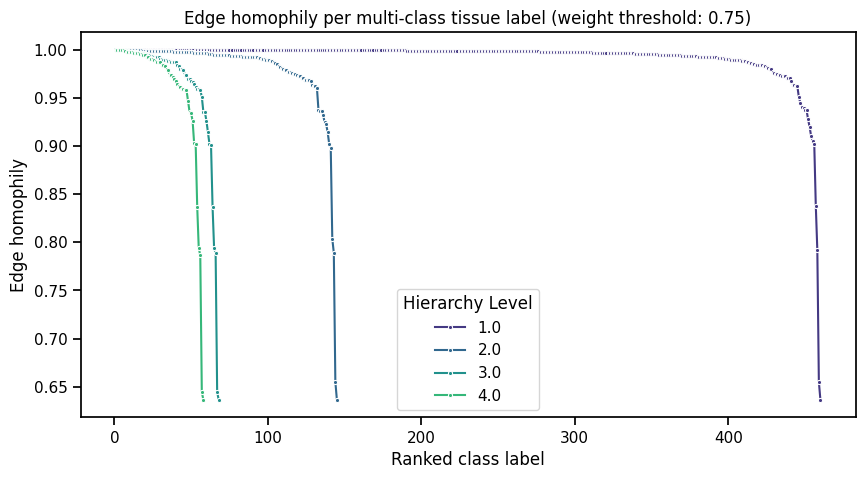

In [23]:
def plot_multi_class_homophily_by_class():
    if not IS_MULTI_LABEL:
        return
    
    weight_threshold = WEIGHT_THRESHOLD

    if os.path.exists(f'/mnt/graphdata/lpa/homophily_plot_data_class_breakdown_{METADATA_TYPE}.csv'):
        homophily_df = pd.read_csv(f'/mnt/graphdata/lpa/homophily_plot_data_class_breakdown_{METADATA_TYPE}.csv')
    else: 
        homophily_rows = []
        # hierarchy_level = 2
        for hierarchy_level in range(1, 5):
        # for weight_threshold in np.arange(0.65, 0.95, 0.25):
            data, mappings = create_pyg_graph(hierarchy_level=hierarchy_level, weight_threshold=weight_threshold)

            for i in range(data['sotu'].x.shape[1]):
                edge_homophily, node_homophily, class_insensitive_homophily = get_single_class_homophily_of_multi_encoding(data['sotu'].edge_index, data['sotu'].x, i)
                homophily_rows.append({
                    'Hierarchy Level': hierarchy_level,
                    'Class label': i,
                    'Edge homophily': edge_homophily,
                    'Node homophily': node_homophily,
                    'Class-insensitive homophily': class_insensitive_homophily,
                    'Weight Threshold': weight_threshold,
                })
        homophily_df = pd.DataFrame(homophily_rows)
        homophily_df.to_csv(f'/mnt/graphdata/lpa/homophily_plot_data_class_breakdown_{METADATA_TYPE}_isolated.csv', index=False)

    homophily_key = 'Edge homophily' # 'Edge homophily', 'Node homophily', 'Class-insensitive homophily'
    homophily_df['Class rank'] = homophily_df.groupby('Hierarchy Level')[homophily_key].rank(ascending=False)

    # remove isolated nodes from the plot
    if REMOVE_ISOLATED_NODES:
        homophily_df = homophily_df[homophily_df['Edge homophily'] < 1.0]

    sns.set_context("paper")
    sns.set_context("notebook")
    plt.figure(figsize=(10, 5))
    palette = sns.color_palette("viridis", n_colors=5)
    
    sns.lineplot(data=homophily_df, x='Class rank', y=homophily_key, hue='Hierarchy Level', marker='.', palette=palette)
    plt.xlabel('Ranked class label')
    class_str = 'multi-class' if IS_MULTI_LABEL else 'single-class'
    # plt.ylim(0, 1)
    plt.title(f'{homophily_key} per multi-class {METADATA_TYPE} label (weight threshold: {weight_threshold})')
    plt.show()

plot_multi_class_homophily_by_class()

Class label: 239
Edge homophily: 0.8980605602264404
Number of tissues: 48
List of tissues: carpel, gynoecium, flower, corolla, perianth, calyx, cob, spike, cone, corona, disc, nectary, nectar, honey, plant_ovary, petal, receptacle, flower_stalk, spadix, stigma, style, sepal, female_cone, male_cone, abscission_zone, tepal, spikelet, hypanthium, lupulin_gland, glume, corn_silk, seed_vessel, labellum, plant_septum, plant_lip, awn, corolla_tube, gynophore, gynostemium, gynoecial_nectary, sepal_nectary, staminal_nectary, petal_nectary, extrastaminal_nectary, nectary_parenchyma, plant_ear, plant_placenta, palea
Class label: 287
Edge homophily: 0.655099630355835
Number of tissues: 33
List of tissues: tissues,_cell_types_and_enzyme_sources, animal, fungal_cell_line, fungus, plant, other_source, commercial_preparation, haustorium, haustorial_mother_cell, Koji_culture, plasmodium, mycobiont, mycorrhiza, pseudoplasmodium, aggregation_stage, slug_stage, ectomycorrhiza, endomycorrhiza, endectomycor

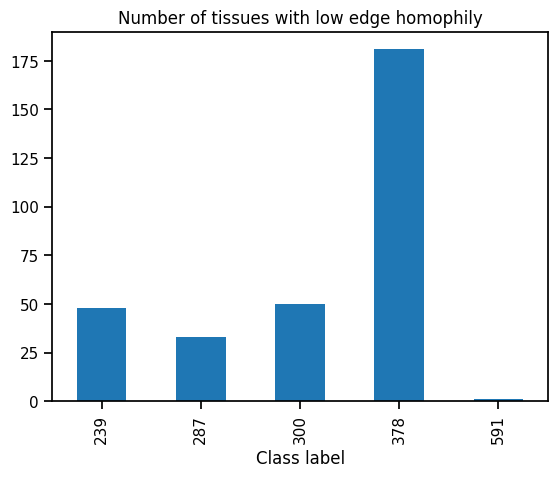

In [11]:
# Inspect high/low homphily classes

homophily_class_df = pd.read_csv(f'/mnt/graphdata/lpa/homophily_plot_data_class_breakdown_{METADATA_TYPE}.csv')
metadata_fts = pd.read_csv(f'{FEATURES_DIR}/tissue_leiden_communities.csv', index_col=False)
tissue_df = pd.read_csv(f'{DATA_DIR}/all_tissues.csv', index_col=False)

hierarchy_level = 2
homophily_class_df = homophily_class_df[homophily_class_df['Hierarchy Level'] == hierarchy_level]

# get all rows with edge homophily < 0.9
homophily_class_df = homophily_class_df[homophily_class_df['Edge homophily'] < 0.9]
class_labels = homophily_class_df['Class label'].unique()

target_homophily_rows = []
for class_idx in class_labels:
    class_idx = int(class_idx)
    class_label = mappings['sotu_x'][class_idx]
    rows = metadata_fts[metadata_fts['intermediateCommunityIds'].apply(lambda x: ast.literal_eval(x)[hierarchy_level] == class_label)]

    for idx, row in rows.iterrows():
        name = tissue_df[tissue_df['btoId'] == row['appId']]['scientificName'].values[0]
        target_homophily_rows.append({
            'Class label': class_label,
            'Class index': class_idx,
            'appId': row['appId'],
            'nodeId': row['nodeId'],
            'scientificName': name,
            'Edge homophily': homophily_class_df[homophily_class_df['Class label'] == class_idx]['Edge homophily'].values[0]
    })

target_homophily_rows = pd.DataFrame(target_homophily_rows)

groups = target_homophily_rows.groupby('Class label')
groups.size().plot(kind='bar', title='Number of tissues with low edge homophily')

for name, group in groups:
    # create list of scientific names with spaces replaced by underscores
    names = group['scientificName'].apply(lambda x: x.replace(' ', '_')).values
    print(f'Class label: {name}')
    # print homophily 
    homophily = group['Edge homophily'].values[0]
    print(f'Edge homophily: {homophily}')

    print(f'Number of tissues: {len(names)}')
    print(f'List of tissues: {", ".join(names)}')

In [86]:
# Subgraph analysis scrap

df = pd.read_csv(f'{DATA_DIR}/sotu_has_host_stat_edges.csv', index_col=False)
print(df.weight.min(), df.weight.max())
human_edges = df.loc[(df['targetAppId'] == 9443) & (df['weight'] > 0.5)]
# human_edges = df.loc[(df['targetAppId'] == 9989) & (df['weight'] > 0.5)]
human_sotus = human_edges['sourceAppId'].unique()

# print(list(mappings['sotu'].items())[:5])
# use mappings to get index of human sotus
human_sotu_idx = [mappings['sotu'][sotu] for sotu in human_sotus]

# get classes of human sotus
human_classes = data['sotu'].x[human_sotu_idx]
# remove duplicates
human_classes = np.unique(human_classes, axis=0)
# print(human_classes)

human_classes = torch.tensor(human_classes)

human_subgraph = subgraph(human_classes, data['sotu'].edge_index, relabel_nodes=True)

single_class_homophily(human_subgraph[0], data['sotu'].x)



classes = data['sotu'].x
# print(classes.shape)
# get nodes with targetLevel != -1
subset = classes[classes != -1]
# subset = classes[classes < classes.max()]
# subset = classes[classes == 2728]
# subset = torch.where(classes == 4158)[0]

#  convert to long
# subset = subset.long()
# get unique values
# subset = torch.unique(subset)
print(subset.shape)
print(subset[0])

# get subgraph of nodes with targetLevel != -1
subgraph_data = subgraph(
    subset=subset[0:4],
    edge_index=data['sotu'].edge_index,
    relabel_nodes=False,
)
print(subgraph_data[0].shape)
print(data['sotu'].edge_index.shape)
single_class_homophily(subgraph_data[0], data['sotu'].x)


0.10932 1.0


IndexError: index 46528 is out of bounds for dimension 0 with size 1439